# **Fine Tune BERT model for Text Classification (Spam or Non-Spam)**


> This approach involves fine-tuning a pre-trained BERT model by adding a new classification layer on top while keeping the pre-trained weights frozen. The added layer is a fully connected layer that maps BERT's output embeddings to the two target classes: "Spam" and "Non-Spam."  

> By freezing the pre-trained weights, the model retains its rich linguistic understanding gained from training on a large corpus, while the newly added layer learns task-specific patterns from the labeled dataset. This method is computationally efficient and minimizes the risk of overfitting, making it ideal for scenarios with limited data or resources.  

> The resulting model effectively classifies text messages or emails as spam or non-spam with high accuracy and robustness.








# **Install Transformers Library**

> Installing Huggingface’s transformers library. This library lets you import a wide range of transformer-based pre-trained models



```
!pip install transformers
```




In [1]:
!pip install transformers

# **Import Libraries**

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

import warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

> Download spam dataset from this [Link](https://raw.githubusercontent.com/ChiragB254/ContextualAI/refs/heads/main/Fine-Tune%20BERT/spamdata.txt) or from my directly from my [Github Repo ](https://github.com/ChiragB254/ContextualAI/tree/main/Fine-Tune%20BERT)and upload it into your Colab notebook runtime.

In [3]:
df = pd.read_csv("/content/spamdata.txt")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# **Split this dataset into three sets – train, validation, and test**

In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# **Import BERT Model and BERT Tokenizer**

> We will import the BERT-base model that has 110 million parameters not BERT large with 340 million param one

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# **Tokenize the Sentences**

> But before tokenization we are checking what is the most comman length and the length which cover most of the text in the dataset so that we can use padding according to that not by max length of the message of the data

<Axes: >

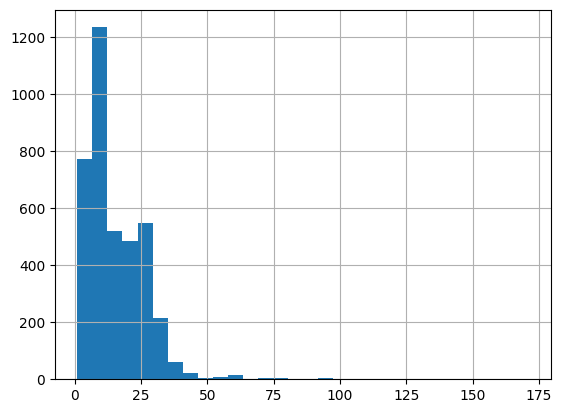

In [6]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [7]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# **Convert the integer sequences to tensors**

In [8]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# **Dataloaders Creation**

> We will create dataloaders for both train and validation set. These dataloaders will pass batches of train data and validation data as input to the model during the training phase.

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# **Define Model Architecture**

> 🔥 Most important first freeze all the layers of the model before fine-tuning it.



In [10]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# **Define our model architecture**

In [11]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [12]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

> # **Use AdamW as our optimizer, an improved version of the Adam optimizer**

In [13]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# **Class Imbalance handling**

> There is a class imbalance in our dataset. The majority of the observations are not spam. So, we will first compute class weights for the labels in the train set and then pass these weights to the loss function so that it takes care of the class imbalance.

In [14]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
# Pass arguments as keyword arguments
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [15]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 20

# **Fine-Tune BERT**

> ## Function to train the model

In [19]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # print(sent_id)
    # print(mask.shape)
    # print(labels.shape)

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


> ## Function to evaluate the model

In [17]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


# **Starting fine-tuning of the model**

In [20]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.548

 Epoch 2 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.551
Validation Loss: 0.522

 Epoch 3 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.527
Validation Loss: 0.500

 Epoch 4 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.512
Validation Loss: 0.484

 Epoch 5 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.492
Validation Loss: 0.464

 Epoch 6 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.478
Validation Loss: 0.445

 Epoch 7 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.458
Validation Loss: 0.432

 Epoch 8 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.449
Validat

# **Saving the weights for future usage**

In [21]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-21-5a29cc8ec3f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

# **Make Predictions**

In [22]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

> ## Model’s performance

In [23]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       724
           1       0.57      0.90      0.70       112

    accuracy                           0.90       836
   macro avg       0.78      0.90      0.82       836
weighted avg       0.93      0.90      0.91       836



# **User Friendly block**

> A user friendly block to test with your own random message. This model still need some traing as you see I trained it only on 20 epochs and data was not too much *( not a large dataset)* so it might give you incorrect results.

In [37]:
import warnings
warnings.filterwarnings('ignore')

# Display a friendly welcome message
print("\nWelcome to the Spam Detection System!")
print("This tool will help you identify if a message is spam or not.\n")

# Infinite loop to allow multiple checks
while True:
    # Get user input
    user_input = input("Enter your message (or type 'exit' to quit): ").strip()

    # Exit condition
    if user_input.lower() == 'exit':
        print("\nThank you for using the Spam Detection System. Goodbye!")
        break

    # Check for empty input
    if not user_input:
        print("⚠️ Please enter a valid message!")
        continue

    # Tokenize user input
    tokens_user_input = tokenizer.batch_encode_plus(
        [user_input],
        max_length=25,
        pad_to_max_length=True,
        truncation=True
    )
    user_input_seq = torch.tensor(tokens_user_input['input_ids'])
    user_input_mask = torch.tensor(tokens_user_input['attention_mask'])
    print('\n')

    # Perform prediction
    with torch.no_grad():
        user_input_preds = model(user_input_seq.to(device), user_input_mask.to(device))
        user_input_preds = user_input_preds.detach().cpu().numpy()
        user_input_preds = np.argmax(user_input_preds, axis=1)
        # Output the result
        if user_input_preds == 0:
            print("\033[1m✅ Your message is NOT SPAM.\033[0m\n")
        else:
            print("\033[1m🚨 Your message is SPAM.\033[0m\n")



Welcome to the Spam Detection System!
This tool will help you identify if a message is spam or not.

Enter your message (or type 'exit' to quit): Haha just kidding, papa needs drugs


✅ Your message is NOT SPAM.

Enter your message (or type 'exit' to quit): SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


🚨 Your message is SPAM.

Enter your message (or type 'exit' to quit): Exit

Thank you for using the Spam Detection System. Goodbye!





---



\begin{array}{|c|}
\hline
\textbf\\
\textbf{ Thank You} \\
\text{ } \\
\textbf{**** End Of Notebook ****} \\
\text{ } \\
\hline
\end{array}
